In [56]:
import pandas as pd
import string
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, ParameterSampler
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

import numpy as np

from nltk.tokenize.casual import TweetTokenizer
tokenizer = TweetTokenizer(reduce_len=True)

# Feature Engineering

In [2]:
# read the raw data and show the data
raw_data = pd.read_csv("./Data/Raw/ExtractedTweets.csv")
raw_data.head()

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...


In [3]:
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

def remove_punctuations(t):
    t = re.sub('@\w+','', t)
    t = "".join([char for char in t if char not in string.punctuation])
    t = re.sub('[0-9]+', '', t)
    return t

def tokenization(t):
    t = re.split('\W+', t)
    return t

def remove_stop_words(t):
    t = [word for word in t if word not in stopword]
    t = [word for word in t if word not in ['rt']]
    return t

def stemming(t):
    t = [ps.stem(word) for word in t]
    return t

In [4]:
def cleaner(t):
    t = remove_punctuations(t).lower()
    t = tokenization(t)
    t = remove_stop_words(t)
    t = stemming(t)
    return t

In [5]:
raw_data['cleaned'] = raw_data.Tweet.apply(lambda x: " ".join(cleaner(x)))
raw_data.head(10)

,Party,Handle,Tweet,cleaned
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",today senat dem vote savetheinternet proud sup...
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,winter resid alta vista teacher one sever reco...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,note hurrican maria left approxim billion dama...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,meet thank take time meet ed marucci guzman na...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,hurrican season start june st puerto rico read...
5,Democrat,RepDarrenSoto,RT @EmgageActionFL: Thank you to all who came ...,thank came orlando gala success night would po...
6,Democrat,RepDarrenSoto,Hurricane Maria left approx $90 billion in dam...,hurrican maria left approx billion damag yet b...
7,Democrat,RepDarrenSoto,RT @Tharryry: I am delighted that @RepDarrenSo...,delight vote cra overrul fcc save netneutr rul...
8,Democrat,RepDarrenSoto,RT @HispanicCaucus: Trump's anti-immigrant pol...,trump antiimmigr polici hurt small busi across...
9,Democrat,RepDarrenSoto,RT @RepStephMurphy: Great joining @WeAreUnidos...,great join roundtabl orlando feder issu affect...


In [11]:
X_train, X_test, y_train, y_test = train_test_split(raw_data.cleaned,raw_data.Party, stratify=raw_data.Party, test_size = 0.2, random_state=123)

# Model Selection

In [13]:
nb_pipleline = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', MultinomialNB())
])

In [9]:
nb_pipleline.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fdaf08b4b00>>)),
                ('classifier', MultinomialNB())])

In [10]:
preds = nb_pipleline.predict(X_test)
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, preds), 4))))

Accuracy: 0.7554


## Gridsearch on naive bayes

In [11]:
%time
nb_params = [{'classifier__alpha': [3,2,1,0.1, 0.01, 0.001, 0.0001, 0.00001]}]
gs = GridSearchCV(estimator=nb_pipleline, param_grid=nb_params, refit=True, cv=4, n_jobs=-1, verbose=10)
gs.fit(X_train, y_train)
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  13 out of  32 | elapsed:   19.1s remaining:   28.0s
[Parallel(n_jobs=-1)]: Done  17 out of  32 | elapsed:   19.7s remaining:   17.4s
[Parallel(n_jobs=-1)]: Done  21 out of  32 | elapsed:   20.3s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  25 out of  32 | elapsed:   26.3s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:   26.6s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   26.8s finished


Best Accuracy: 75.94%
Best Params: {'classifier__alpha': 0.1}


<BarContainer object of 8 artists>

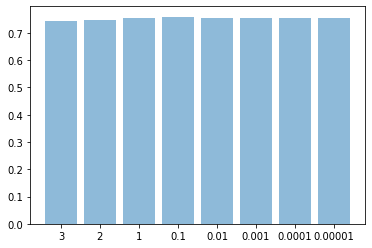

In [12]:
plt.bar(['3','2','1','0.1', '0.01', '0.001', '0.0001', '0.00001'],gs.cv_results_['mean_test_score'],align='center', alpha=0.5 )

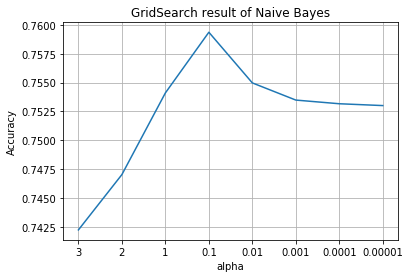

In [13]:
mean_scores_gs = gs.cv_results_['mean_test_score']
C_gs = np.array(['3','2','1','0.1', '0.01', '0.001', '0.0001', '0.00001'])

fig, ax = plt.subplots()
ax.plot(C_gs, mean_scores_gs)

ax.set(xlabel='alpha', ylabel='Accuracy',
       title='GridSearch result of Naive Bayes')
ax.grid()

plt.savefig("NB_gs.png")
plt.show()

In [14]:
nb_pipleline = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', MultinomialNB(alpha=0.1))
])


In [17]:
%time
nb_pipleline.fit(X_train, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fd759806be0>>)),
                ('classifier', MultinomialNB(alpha=0.1))])

In [15]:
nb_scores = cross_val_score(nb_pipleline, X_train, y_train, cv=4, n_jobs=-1)

In [16]:
nb_cv_avg = nb_scores.sum()/4

In [34]:
nb_cv_avg = 0.7593684941013185

## SVM

In [19]:
svm_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', SVC(kernel='linear', C=1))
])

In [19]:
svm_scores = cross_val_score(svm_pipe, X_train, y_train, cv=4, n_jobs=-1)
svm_scores

array([0.75693963, 0.75393245, 0.75399028, 0.75722878])

In [20]:
svm_cv_avg = svm_scores.sum()/4
svm_cv_avg

0.7555227851029378

In [33]:
svm_cv_avg = 0.7642840619939857

In [20]:
%time
svm_pipe.fit(X_train, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fd759806be0>>)),
                ('classifier', SVC(C=1, kernel='linear'))])

### Gridsearch on SVM
We will use linear kernal in this case, the only hyperparameter that we care is c

In [23]:
svm_params = [{'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}]
gs_svm_linear = GridSearchCV(estimator=svm_pipe, param_grid=svm_params, refit=True, cv=4, n_jobs=-1)
gs_svm_linear.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print('Best Accuracy: %.2f%%' % (gs_svm_linear.best_score_*100))
print('Best Params:', gs_svm_linear.best_params_)

In [ ]:
gs_svm_linear.cv_results_

In [ ]:
mean_scores_gs = np.array([0.51344552, 0.51344552, 0.56361323, 0.7233981 , 0.75552279, 0.74660248])
C_gs = np.array(['0.0001', '0.001', '0.01', '0.1', '1', '10'])

fig, ax = plt.subplots()
ax.plot(C_gs, mean_scores_gs)

ax.set(xlabel='C', ylabel='Accuracy',
       title='GridSearch result of support vector machine')
ax.grid()

plt.savefig('SVM_GS.png')
plt.show()

## Randomnized search on XGBoost

In [ ]:
import scipy.stats

d = {'classifier__max_depth':[5,6,7,8,9,10],
     'classifier__min_child_weight': scipy.stats.uniform(loc=0, scale=10),
     'classifier__eta': scipy.stats.uniform(loc=0, scale=2)}

In [ ]:
xgb_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.2, nthreads=-1))
])

rs = RandomizedSearchCV(estimator=xgb_pipe, param_distributions=d, n_iter=10, cv=4, refit=True, random_state=123, n_jobs=-1)

In [ ]:
xgb_pipe.fit(X_train, y_train)
xgb_preds = xgb_pipe.predict(X_test)

In [ ]:
xgb_pipe_best = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', XGBClassifier(max_depth=9, n_estimators=300, learning_rate=1.06, min_child_weight=4.27, nthreads=-1))
])

xgb_pipe_best.fit(X_train, y_train)

In [ ]:
xgb_pipe_best = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', XGBClassifier(max_depth=9, n_estimators=300, learning_rate=1.06, min_child_weight=4.27, nthreads=-1))
])

xgb_pipe_best.fit(X_train, y_train)

In [21]:
xgb_pipe_best_1 = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', XGBClassifier(max_depth=10, n_estimators=200, learning_rate=1.06, min_child_weight=4.27, nthreads=-1))
])

In [22]:
%time
xgb_pipe_best_1.fit(X_train, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fd759806be0>>)),
                ('classifier',
                 XGBClassifier(learning_rate=1.06, max_depth=10,
                               min_child_weight=4.27, n_estimators=200,
                               nthreads=-1))])

In [ ]:
xgb_best_1_preds = xgb_pipe_best_1.predict(X_test)

In [ ]:
accuracy_score(xgb_best_1_preds, y_test)

In [ ]:
svm_scores_1 = cross_val_score(xgb_pipe_best_1, X_train, y_train, cv=4, n_jobs=-1)
xgb_cv_avg_1 = xgb_scores.sum()/4

In [32]:
xgb_cv_avg_1 = 0.7006708304418228

In [ ]:
xgb_scores = cross_val_score(xgb_pipe_best, X_train, y_train, cv=4, n_jobs=-1, verbose=10)

In [ ]:
xgb_cv_avg = xgb_scores.sum()/4

In [ ]:
xgb_cv_avg

In [30]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


In [ ]:
model_names = np.array(['naive bayes', 'SVM', 'XGBOOST'])
model_test_acc = np.array([nb_cv_avg, svm_cv_avg, xgb_cv_avg_1])
fig, ax = plt.subplots()
rect = ax.bar(model_names, model_test_acc)
plt.ylim([0.65,0.8])
autolabel(rect)
plt.title("4-Fold Cross Validation Accuracy of Three Models")
fig.tight_layout()

plt.show()
plt.savefig('CV_ALL.png')

From this plot we can see that both naive bayes and SVM perform a noticeble better amount than xgboost

## Model Evaluation

Since we already selected the following models:
    1. svm
    2. multinomial naive bayes
    3. XGBoost
    4. Decision Tree

In [18]:
%time
nb_pred = nb_pipleline.predict(X_test)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [23]:
%time
svm_pred = svm_pipe.predict(X_test)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 31 µs


In [24]:
xgb_pred = xgb_pipe_best_1.predict(X_test)

In [25]:
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, nb_pred), 4))))
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, svm_pred), 4))))
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, xgb_pred), 4))))

Accuracy: 0.7569
Accuracy: 0.7533
Accuracy: 0.7007


In [26]:
nb_test_score = round(accuracy_score(y_test, nb_pred), 2)
svm_test_score = round(accuracy_score(y_test, svm_pred), 2)
xgb_test_score = round(accuracy_score(y_test, xgb_pred), 2)

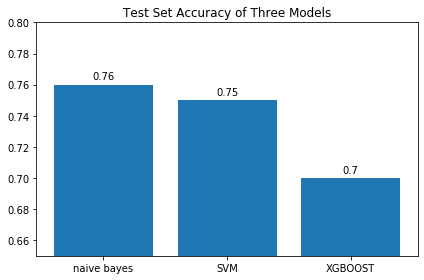

In [31]:
model_names = np.array(['naive bayes', 'SVM', 'XGBOOST'])
model_test_acc = np.array([nb_test_score, svm_test_score, xgb_test_score])
fig, ax = plt.subplots()
rect = ax.bar(model_names, model_test_acc)
plt.ylim([0.65,0.8])
autolabel(rect)
plt.title("Test Set Accuracy of Three Models")
fig.tight_layout()

plt.savefig('TEST_ALL.png')
plt.show()

In [28]:
labels = ['Naive Bayes', 'SVM', 'XGBoost']
cv_scores = [round(nb_cv_avg,2), round(svm_cv_avg,2), round(xgb_cv_avg_1,2)]
test_scores = [nb_test_score, svm_test_score, xgb_test_score]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cv_scores, width, label='cross validation')
rects2 = ax.bar(x + width/2, test_scores, width, label='test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Different Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.ylim(0.6,0.8)

autolabel(rects1)
autolabel(rects2)

fig.set_figheight(8)
fig.tight_layout()

plt.show()

NameError: name 'nb_cv_avg' is not defined

# Random Forest

In [ ]:
RF_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', RandomForestClassifier(n_jobs=-1, verbose = 10))
])

In [ ]:
RF_pipe.fit(X_train,y_train)

In [ ]:
RF_scores = cross_val_score(RF_pipe, X_train, y_train, cv=4, n_jobs=-1)

In [ ]:
RF_scores.sum()/4

# Model Comparision
Naive Bayes vs SVM

In [37]:
from sklearn.metrics.cluster import contingency_matrix

In [39]:
svm_cm = contingency_matrix(svm_pred, nb_pred)

In [40]:
svm_cm

array([[6758, 1222],
       [1056, 8256]])

In [42]:
nb_cm_true = contingency_matrix(nb_pred, y_test)
nb_cm_true

array([[6012, 1802],
       [2402, 7076]])

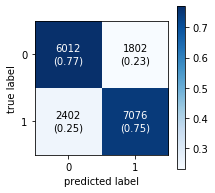

In [59]:
fig, ax = plot_confusion_matrix(conf_mat=nb_cm_true,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                figsize=(3, 3))
plt.savefig("nb_cm.png")
plt.show()

In [43]:
svm_cm_true = contingency_matrix(svm_pred, y_test)
svm_cm_true

array([[6064, 1916],
       [2350, 6962]])

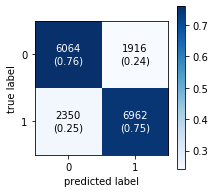

In [60]:
fig, ax = plot_confusion_matrix(conf_mat=svm_cm_true,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                figsize=(3, 3))
plt.savefig("svm_cm.png")
plt.show()

In [41]:
from statsmodels.stats.contingency_tables import mcnemar
result_mcnemar = mcnemar(svm_cm, exact=True)
print('statistic=%.3f, p-value=%.3f' % (result_mcnemar.statistic, result_mcnemar.pvalue))
alpha = 0.05
if result_mcnemar.pvalue > alpha:
    print('Same proportions of errors (fail to reject H0)')
else:
    print('Different proportions of errors (reject H0)')

statistic=1056.000, p-value=0.001
Different proportions of errors (reject H0)


In [52]:
from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, f1_score, matthews_corrcoef

def metrics(y_pred):
    print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, pos_label="Republican"))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, pos_label="Republican"))
    print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, pos_label="Republican"))
    print('MCC: %.3f' % matthews_corrcoef(y_true=y_test, y_pred=y_pred))

In [53]:
svm_pred

array(['Republican', 'Democrat', 'Republican', ..., 'Democrat',
       'Republican', 'Republican'], dtype=object)

In [54]:
metrics(svm_pred)

Accuracy: 0.753
Precision: 0.748
Recall: 0.784
F1: 0.765
MCC: 0.506


In [55]:
metrics(nb_pred)

Accuracy: 0.757
Precision: 0.747
Recall: 0.797
F1: 0.771
MCC: 0.514


# Discussion
CV vs. .632+, for complicated model (large number of features), should we use cross-validation or .632+?

We will test all three of our models to see the result of 0.632,0.632+, cv and test result.